# Structured prediction



In this example$\newcommand{\reals}{\mathbf{R}}$$\newcommand{\ones}{\mathbf{1}}$, we fit a regression model to structured data, using an LLCP.
The training dataset $\mathcal D$ contains $N$ input-output pairs $(x, y)$,
where $x \in \reals^{n}_{++}$ is an input and $y \in \reals^{m}_{++}$ is an
outputs. The entries of each output $y$ are sorted in ascending order, meaning
$y_1 \leq y_2 \leq \cdots y_m$.

Our regression model $\phi : \reals^{n}_{++} \to \reals^{m}_{++}$ takes as
input a vector $x \in \reals^{n}_{++}$, and solves an LLCP to produce a
prediction $\hat y \in \reals^{m}_{++}$. In particular, the solution of the
LLCP is model's prediction. The model is of the form
$$
\begin{equation}
\begin{array}{lll}
\phi(x) = &
\mbox{argmin} & \ones^T (z/y + y / z) \\
& \mbox{subject to} &  y_i \leq y_{i+1}, \quad i=1, \ldots, m-1 \\
&& z_i = c_i x_1^{A_{i1}}x_2^{A_{i2}}\cdots x_n^{A_{in}}, \quad i = 1, \ldots, m.
\end{array}\label{e-model}
\end{equation}
$$
Here, the minimization is over $y \in \reals^{m}_{++}$ and an auxiliary
variable $z \in \reals^{m}_{++}$, $\phi(x)$ is the optimal value of $y$, and
the parameters are $c \in \reals^{m}_{++}$ and $A \in \reals^{m \times n}$. The
ratios in the objective are meant elementwise, as is the inequality $y \leq z$, and
$\ones$ denotes the vector of all ones. Given a vector $x$, this model finds a
sorted vector $\hat y$ whose entries are close to monomial functions of $x$
(which are the entries of $z$), as measured by the fractional error.


The training loss
$\mathcal{L}(\phi)$ of the model on the training set is the mean squared loss
$$
\mathcal{L}(\phi) = \frac{1}{N}\sum_{(x, y) \in \mathcal D} \|y - \phi(x)\|_2^2.
$$
We emphasize that $\mathcal{L}(\phi)$ depends on $c$ and $A$.
In this example, we fit the parameters $c$ and $A$ in the LLCP 
to minimize the training loss $\mathcal{L}(\phi)$.

**Fitting.** We fit the parameters by an iterative projected
gradient descent method on $\mathcal L(\phi)$. In each iteration, we first
compute predictions $\phi(x)$ for each input in the training set; this requires
solving $N$ LLCPs. Next, we evaluate the training loss $\mathcal L(\phi)$. To
update the parameters, we compute the gradient $\nabla \mathcal L(\phi)$ of the
training loss with respect to the parameters $c$ and $A$. This
requires differentiating through the solution map of the LLCP. We can compute this gradient efficiently, using the ``backward`` method in CVXPY
(or CVXPY Layers). Finally, we subtract
a small multiple of the gradient from the parameters. Care must be taken to
ensure that $c$ is strictly positive; this can be done by clamping the entries
of $c$ at some small threshold slightly above zero. We run this method for
a fixed number of iterations.

This example is described in the paper [Differentiating through Log-Log Convex Programs](http://web.stanford.edu/~boyd/papers/pdf/diff_llcvx.pdf).

Shane Barratt formulated the idea of using an optimization layer to regress on sorted vectors.

**Requirements.**
This example requires PyTorch and CvxpyLayers >= v0.1.3.

In [1]:
from cvxpylayers.torch import CvxpyLayer


import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.set_default_tensor_type(torch.DoubleTensor)
%matplotlib inline

### Data generation

In [2]:
n = 20
m = 10

# Number of training input-output pairs
N = 100

# Number of validation pairs
N_val = 50

In [3]:
torch.random.manual_seed(243)
np.random.seed(243)

normal = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n), torch.eye(n))
lognormal = lambda batch: torch.exp(normal.sample(torch.tensor([batch])))

A_true = torch.randn((m, n)) / 10
c_true = np.abs(torch.randn(m))

In [4]:
def generate_data(num_points, seed):
    torch.random.manual_seed(seed)
    np.random.seed(seed)
    
    latent = lognormal(num_points)
    noise = lognormal(num_points)
    inputs = noise + latent

    input_cp = cp.Parameter(pos=True, shape=(n,))
    prediction = cp.multiply(c_true.numpy(), cp.gmatmul(A_true.numpy(), input_cp))
    y = cp.Variable(pos=True, shape=(m,))
    objective_fn = cp.sum(prediction / y + y/prediction)
    constraints = []
    for i in range(m-1):
        constraints += [y[i] <= y[i+1]]
    problem = cp.Problem(cp.Minimize(objective_fn), constraints)
    
    outputs = []
    for i in range(num_points):
        input_cp.value = inputs[i, :].numpy()
        problem.solve(cp.SCS, gp=True)
        outputs.append(y.value)
    return inputs, torch.stack([torch.tensor(t) for t in outputs])

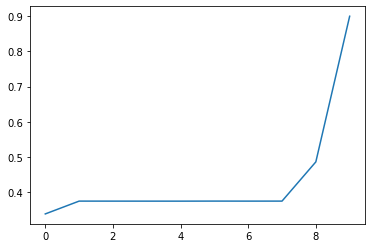

In [5]:
train_inputs, train_outputs = generate_data(N, 243)
plt.plot(train_outputs[0, :].numpy())

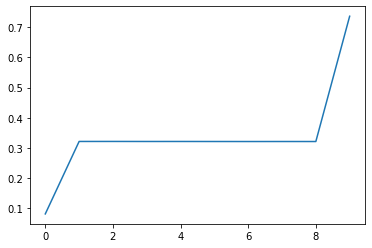

In [6]:
val_inputs, val_outputs = generate_data(N_val, 0)
plt.plot(val_outputs[0, :].numpy())

## Monomial fit to each component

We will initialize the parameters in our LLCP model by fitting monomials to the training data, without enforcing the monotonicity constraint.

In [7]:
log_c = cp.Variable(shape=(m,1))
theta = cp.Variable(shape=(n, m))
inputs_np = train_inputs.numpy()
log_outputs_np = np.log(train_outputs.numpy()).T
log_inputs_np = np.log(inputs_np).T
offsets = cp.hstack([log_c]*N)

In [8]:
cp_preds = theta.T @ log_inputs_np + offsets
objective_fn = (1/N) * cp.sum_squares(cp_preds - log_outputs_np)
lstq_problem = cp.Problem(cp.Minimize(objective_fn))

In [9]:
lstq_problem.is_dcp()

True

In [10]:
lstq_problem.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1210, constraints m = 1000
          nnz(P) + nnz(A) = 23000
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.30e+00   1.22e+04   1.00e-01   3.06e-03s
  50   1.0014e-02   1.72e-07   1.64e-07   1.75e-03   7.37e-03s
plsh   1.0014e-02   1.56e-15   1.17e-14  

0.010014212812318733

In [11]:
c = torch.exp(torch.tensor(log_c.value)).squeeze()
lstsq_val_preds = []
for i in range(N_val):
    inp = val_inputs[i, :].numpy()
    pred = cp.multiply(c,cp.gmatmul(theta.T.value, inp))
    lstsq_val_preds.append(pred.value)

## Fitting

In [12]:
A_param = cp.Parameter(shape=(m, n))
c_param = cp.Parameter(pos=True, shape=(m,))
x_slack = cp.Variable(pos=True, shape=(n,))
x_param = cp.Parameter(pos=True, shape=(n,))
y = cp.Variable(pos=True, shape=(m,))

prediction = cp.multiply(c_param, cp.gmatmul(A_param, x_slack))
objective_fn = cp.sum(prediction / y + y / prediction)
constraints = [x_slack == x_param]
for i in range(m-1):
    constraints += [y[i] <= y[i+1]]
problem = cp.Problem(cp.Minimize(objective_fn), constraints)
problem.is_dgp(dpp=True)

True

In [13]:
A_param.value = np.random.randn(m, n)
x_param.value = np.abs(np.random.randn(n))
c_param.value = np.abs(np.random.randn(m))

layer = CvxpyLayer(problem, parameters=[A_param, c_param, x_param], variables=[y], gp=True)

In [14]:
torch.random.manual_seed(1)
A_tch = torch.tensor(theta.T.value)
A_tch.requires_grad_(True)
c_tch = torch.tensor(np.squeeze(np.exp(log_c.value)))
c_tch.requires_grad_(True)
train_losses = []
val_losses = []

lam1 = torch.tensor(1e-1)
lam2 = torch.tensor(1e-1)

opt = torch.optim.SGD([A_tch, c_tch], lr=5e-2)
for epoch in range(10):
    preds = layer(A_tch, c_tch, train_inputs, solver_args={'acceleration_lookback': 0})[0]
    loss = (preds - train_outputs).pow(2).sum(axis=1).mean(axis=0)

    with torch.no_grad():
        val_preds = layer(A_tch, c_tch, val_inputs, solver_args={'acceleration_lookback': 0})[0]
        val_loss = (val_preds - val_outputs).pow(2).sum(axis=1).mean(axis=0)

    print('(epoch {0}) train / val ({1:.4f} / {2:.4f}) '.format(epoch, loss, val_loss))
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        c_tch = torch.max(c_tch, torch.tensor(1e-8))

(epoch 0) train / val (0.0018 / 0.0014) 
(epoch 1) train / val (0.0017 / 0.0014) 
(epoch 2) train / val (0.0017 / 0.0014) 
(epoch 3) train / val (0.0017 / 0.0014) 
(epoch 4) train / val (0.0017 / 0.0014) 
(epoch 5) train / val (0.0017 / 0.0014) 
(epoch 6) train / val (0.0016 / 0.0014) 
(epoch 7) train / val (0.0016 / 0.0014) 
(epoch 8) train / val (0.0016 / 0.0014) 
(epoch 9) train / val (0.0016 / 0.0014) 


In [15]:
with torch.no_grad():
    train_preds_tch = layer(A_tch, c_tch, train_inputs)[0]
    train_preds = [t.detach().numpy() for t in train_preds_tch]

In [16]:
with torch.no_grad():
    val_preds_tch = layer(A_tch, c_tch, val_inputs)[0]
    val_preds = [t.detach().numpy() for t in val_preds_tch]

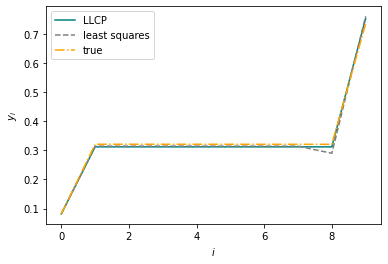

In [17]:
fig = plt.figure()


i = 0
plt.plot(val_preds[i], label='LLCP', color='teal')
plt.plot(lstsq_val_preds[i], label='least squares', linestyle='--', color='gray')
plt.plot(val_outputs[i], label='true', linestyle='-.', color='orange')
w, h = 8, 3.5
plt.xlabel(r'$i$')
plt.ylabel(r'$y_i$')
plt.legend()
plt.show()